In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
# from rich.progress import track


In [2]:
#TODO - problema quando coloca acoes de outros paises
papeis_preditores = ['VALE3.SA','GOAU3.SA', 'BLAU3.SA', 'PETR4.SA']
papeis_preditores = ['PETR4.SA', 'ITUB4.SA']
papel_alvo = 'USIM3.SA'


In [3]:
def coletar_dados_papeis(lista_papeis:list[str], 
                             col=3, periodo = '5y'):
    coluna = ['Open', 'High', 'Low', 'Close', 'Volume',
              'Dividends', 'Stock Splits'][col]
    df_out = pd.DataFrame()
    for papel in lista_papeis:
        acao = yf.Ticker(papel)
        df = acao.history(period=periodo)
        if df.size == 0:
            print(f'Não foi possivel obter os dados de {papel}')
            continue
        df.rename(columns={coluna:papel}, inplace=True)
        df = df[papel]
        df_out = pd.concat((df_out,df), axis=1)
    return df_out

def ajustar_df_alvo(df:pd.DataFrame,dias_no_futuro=1):
    dias_futuro = dias_no_futuro
    data = [df[df.columns[0]].\
            loc[df.index[i]] for i in range(dias_futuro,len(df.index))]
    index = [df.index[i] for i in range(len(df.index)-dias_futuro) ]
    return pd.Series(data, index,name=df.columns[0])
    



In [4]:
#Coletar dados dos preditores
df_preditores = coletar_dados_papeis(papeis_preditores)
#coletar dados do alvo
df_alvo = coletar_dados_papeis([papel_alvo])
#recebendo o ultimo valor do alvo para comparar com o previsto
ultimo_valor = float(df_alvo.iloc[-1].values[0])
#ajustando o df do alvo
df_alvo_ajustado = ajustar_df_alvo(df_alvo)
#unir dados em um unico df
df = pd.concat((df_preditores,df_alvo_ajustado),axis=1).\
        sort_index(ascending=False)

In [5]:
#pegar os dados de hoje para prever informacao
x_hoje = df.sort_index(ascending=False).head()[:1]
x_hoje.drop(papel_alvo,axis=1, inplace=True)

,PETR4.SA,ITUB4.SA
2024-04-23 00:00:00-03:00,41.419998,32.0


In [6]:
#limpar dados nulos
df.dropna(inplace=True)

# separando variaveis
x = df.drop(papel_alvo, axis=1)
y = df[papel_alvo]
#dividinod entre treino e teste
x_treino, x_teste , y_treino, y_teste = train_test_split(
    x,y,
    test_size=0.2,
    random_state=0)
#iniciando modelo
regressor = DecisionTreeRegressor()
regressor.fit(x_treino,y_treino)
#modelo treinado
#fazenod previsao
y_previsto = regressor.predict(x_teste)

#incluindo coluna de previsao no df de teste
x_teste['Previsao']= y_previsto
x_teste.sort_index(inplace=True)

#prevendo valor de amanha
v_dia_seguinte = float(regressor.predict(x_hoje)[0])

In [7]:
print(f'Nome das features : {regressor.feature_names_in_}')
print(f'Importancia das features : {regressor.feature_importances_}')

print('Erro Absoluto Médio:', round(metrics.mean_absolute_error(y_teste, y_previsto),4))
print('Erro Quadrático Médio:', round(metrics.mean_squared_error(y_teste, y_previsto),4))
print('A Raiz do Erro Quadrático Médio (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_teste, y_previsto)),4))

dif = (v_dia_seguinte-ultimo_valor)
print(f'O valor previsto para o dia seguinte é: ', f'[green]' if dif > 0 else f'[red]', f'{v_dia_seguinte :.2f}')
print(f'Uma diferenca % de: ', f'[green] +' if dif > 0 else f'[red] -', f'{dif/ultimo_valor :.2f} %')
print()
print(f'O ultimo valor foi: {ultimo_valor }')


Nome das features : ['PETR4.SA' 'ITUB4.SA']
Importancia das features : [0.58245453 0.41754547]
Erro Absoluto Médio: 1.0192
Erro Quadrático Médio: 3.9168
A Raiz do Erro Quadrático Médio (RMSE): 1.9791
O valor previsto para o dia seguinte é:  [red] 8.35
Uma diferenca % de:  [red] - 0.00 %

O ultimo valor foi: 8.350000381469727


In [8]:
for nome, importancia in zip(regressor.feature_names_in_,regressor.feature_importances_):
        if importancia < 0.4:
            papeis_preditores.remove(nome)
print(papeis_preditores)
                

['PETR4.SA', 'ITUB4.SA']


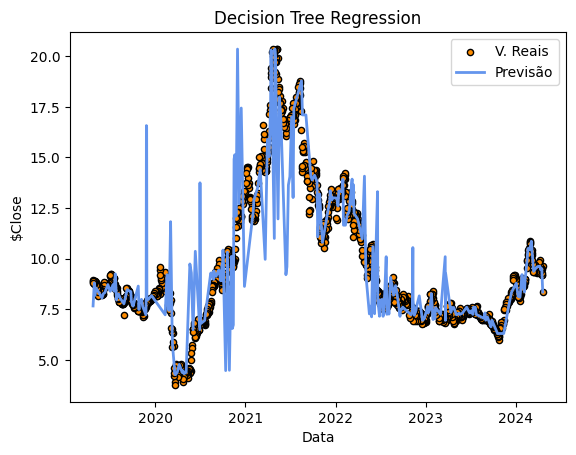

In [9]:
# Plot the results
plt.figure()
plt.scatter(y.index, y, s=20, edgecolor="black",
            c="darkorange", label="V. Reais")
plt.plot(x_teste.index, x_teste['Previsao'],
         color="cornflowerblue",
         label="Previsão", linewidth=2)
plt.xlabel("Data")
plt.ylabel("$Close")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()